In [3]:
import utils
import pandas
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

from datetime import datetime, date

from scipy.misc import imresize
import features


In [61]:
def not_in_list(x,args,y):
    list = x['caption'].split(' #')
    return not (args in list[1:])

def convertString(x):
    string = str(x)
    if 'k' in string:
        number = float( ''.join(string.split('k')[0].split(',')) ) * 1000
    elif 'm' in string:
        number = float( ''.join(string.split('m')[0].split(',')) ) * 1000000
    else:
        number = float( ''.join(string.split(',')) )
    return number

def extractTimeData(x):
    if (type(x) is unicode):
        createdtime = datetime.fromtimestamp(int(x))
        hour = createdtime.hour
        weekday = createdtime.weekday()
        #date(2017,9,16).weekday()
        return weekday, hour
    elif type(x) is int:
        createdtime = datetime.fromtimestamp(x)
        hour = createdtime.hour
        weekday = createdtime.weekday()
        #date(2017,9,16).weekday()
        return weekday, hour
    else:
        return 7, 25


In [5]:
import utils
import json
import pandas
import features
from scipy.misc import imresize

In [6]:
from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S

List of users

cake.and.sweets.17  ezgipolat       iamdessertlover        lolly_cakery        somepaintings
carolina_nusadua    garrylarduinat  iceandvice             minastaartenwereld  stuffbeneats
cedricgrolet        gunopark        omjsk                  taiyakinyc
dinarakasko         helloemilie     jacquesgenin           pierreherme         way_cake
eightturncrepeny    hungrygrls      jamesjeanart           pollykosheleva

In [57]:
userSpecific = False

if userSpecific:
    posts,images = utils.dataFromScraper('stuffbeneats')
    dfp = pandas.DataFrame(posts)
    bytag = False
    
else:
    bytag = True
    posts, images = utils.getData('posts_icecream_1505846777.json',updated=True,rawimages=True)
    with open('data/users_icecream_1505846777.json','r') as infile:
            users = json.load(infile)
    dfu = pandas.DataFrame(users)
    dfp = pandas.DataFrame(posts)

In [62]:
# Extract image features

nbins = 20
nposts0 = len(posts)
satH = np.zeros([nposts0,nbins])
conH = np.zeros([nposts0,nbins])
sat = np.zeros(nposts0)
contrast = np.zeros(nposts0)

dims = 5
comp = np.zeros([nposts0,dims**2])

kernelCos,kernelSin,kernelCor1,kernelCor2,kernelCor3,kernelCor4 = features.compKernels(dims)
kCos = np.zeros(nposts0)
kSin = np.zeros(nposts0)
kCor1 = np.zeros(nposts0)
kCor2 = np.zeros(nposts0)
kCor3 = np.zeros(nposts0)
kCor4 = np.zeros(nposts0)

for i in range(len(posts)):
    satH[i],_ = np.histogram(features.colorfulness(images[i]), bins=nbins)
    satH[i] = satH[i]/np.sqrt(np.sum(satH[i]**2))
    sat[i] = np.mean(features.colorfulness(images[i]))
    intensity = np.mean(images[i],2)
    conH[i],_ = np.histogram(intensity, bins=nbins)
    conH[i] = conH[i]/np.sqrt(np.sum(conH[i]**2))
    contrast[i] = features.contrast(images[i])
    comp[i] = imresize(intensity,[dims,dims]).reshape([dims**2])

    temp = imresize(intensity,[dims,dims])
    kCos[i] = np.mean(temp*kernelCos)
    kSin[i] = np.mean(temp*kernelSin)
    kCor1[i] = np.mean(temp*kernelCor1)
    kCor2[i] = np.mean(temp*kernelCor2)
    kCor3[i] = np.mean(temp*kernelCor3)
    kCor4[i] = np.mean(temp*kernelCor4)
    

# Extract features

likes = dfp['likes'].apply(lambda x: float(convertString(x))).values
ntags = dfp[u'caption'].apply(lambda x: float( len(x.split(' #')) ) ).values - 1

if userSpecific:
    hour = dfp[u'createdtime'].apply(lambda x: extractTimeData(x)[1]).values
    weekday = dfp[u'createdtime'].apply(lambda x: extractTimeData(x)[0]).values

if bytag:
    followers = dfu['followers'].apply(lambda x: float( convertString(x) )).values
    following = dfu['following'].apply(lambda x: convertString(x)).values
    hour = dfp[u'date'].apply(lambda x: extractTimeData(x)[1]).values
    weekday = dfp[u'date'].apply(lambda x: extractTimeData(x)[0]).values

a = np.array([1, 0, 3])
weekdayvec = np.zeros([nposts0,8])
hourvec = np.zeros([nposts0,26])
weekdayvec[np.arange(nposts0), weekday] = 1
hourvec[np.arange(nposts0), hour] = 1


In [63]:
weekdayvec[0:9]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [67]:
# Normalize data

minsat = np.min(sat)
maxsat = np.max(sat)
mincon = np.min(contrast)
maxcon = np.max(contrast)
minlike = min(likes)
maxlike = max(likes)
mintags = min(ntags)
maxtags = max(ntags)

normSinA = np.abs(kSin)/np.max(np.abs(kSin))

normsat = (sat - minsat)/(maxsat-minsat)
normcontrast = (contrast - mincon)/(maxcon-mincon)
normlikes = (likes - minlike)/(maxlike - minlike)
normcomp = comp/255.
normNtags = (ntags - np.mean(ntags))/(maxtags - mintags)
normCos = (kCos - np.mean(kCos))/(np.max(kCos) - np.min(kCos))
normSin = (kSin - np.mean(kSin))/(np.max(kSin) - np.min(kSin))


# Vectorize data

if bytag:
    
    nfeatures = 1+2+4+1+1+1+7+24+2
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = normCos
    data[:,1] = normSin
    data[:,2] = normSinA
    data[:,3] = kCor1/np.max(kCor1)
    data[:,4] = kCor2/np.max(kCor2)
    data[:,5] = kCor3/np.max(kCor3)
    data[:,6] = kCor4/np.max(kCor4)
    data[:,7] = normsat
    data[:,8] = normcontrast
    data[:,9] = normNtags
    data[:,10:17] = weekdayvec[:,0:7]
    data[:,17:41] = hourvec[:,0:24]
    data[:,41] = followers
    data[:,42] = following

else:
        
    nfeatures = 1+2+4+1+1+1+7+24
    data = np.zeros([nposts0,nfeatures])
    data[:,0] = normCos
    data[:,1] = normSin
    data[:,2] = normSinA
    data[:,3] = kCor1/np.max(kCor1)
    data[:,4] = kCor2/np.max(kCor2)
    data[:,5] = kCor3/np.max(kCor3)
    data[:,6] = kCor4/np.max(kCor4)
    data[:,7] = normsat
    data[:,8] = normcontrast
    data[:,9] = normNtags
    data[:,10:17] = weekdayvec[:,0:7]
    data[:,17:] = hourvec[:,0:24]



Without feature 00:
MSE: 0.000001
R2S: 0.193717
Without feature 01:
MSE: 0.000001
R2S: 0.189045
Without feature 02:
MSE: 0.000001
R2S: 0.188253
Without feature 03:
MSE: 0.000001
R2S: 0.190873
Without feature 04:
MSE: 0.000001
R2S: 0.191148
Without feature 05:
MSE: 0.000001
R2S: 0.189427
Without feature 06:
MSE: 0.000001
R2S: 0.192083
Without feature 07:
MSE: 0.000001
R2S: 0.183075
Without feature 08:
MSE: 0.000001
R2S: 0.188956
Without feature 09:
MSE: 0.000001
R2S: 0.111747
Without feature 10:
MSE: 0.000001
R2S: 0.189279
Without feature 11:
MSE: 0.000001
R2S: 0.189279
Without feature 12:
MSE: 0.000001
R2S: 0.189279
Without feature 13:
MSE: 0.000001
R2S: 0.189279
Without feature 14:
MSE: 0.000001
R2S: 0.189279
Without feature 15:
MSE: 0.000001
R2S: 0.189279
Without feature 16:
MSE: 0.000001
R2S: 0.189279
Without feature 17:
MSE: 0.000001
R2S: 0.189279
Without feature 18:
MSE: 0.000001
R2S: 0.189279
Without feature 19:
MSE: 0.000001
R2S: 0.189279
Without feature 20:
MSE: 0.000001
R2S: 0

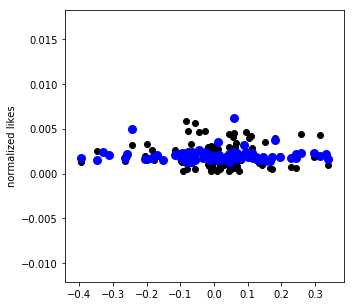

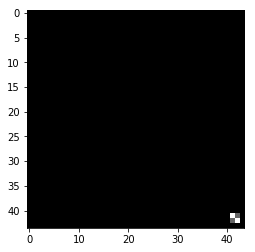

[  3.75647604e-06  -1.13837953e-05  -9.82858609e-06  -1.54315591e-05
  -1.11624364e-05   6.99794775e-06   1.26778759e-05  -2.63828616e-06
   1.06538087e-05   7.75797859e-05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -3.18543079e-05
   5.56905665e-06  -8.28397177e-06   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.15488312e-05
   4.61180543e-05   3.35595402e-01   1.18982702e-01   1.51349449e-06]


In [77]:
# Prune data
    
keep = (likes < 5000) & (likes > 1) #& (ntags < 18)
#keep = dfp.apply(not_in_list,args=[u'fashion',0],axis=1).values & keep

if bytag:
    likeOrder = likes.argsort()
    keep = np.zeros(nposts0, dtype=bool)
    keep[ likeOrder[int(nposts0*.05):int(nposts0*.90)].tolist() ] = True
    followOrder = followers.argsort()
    keep[ followOrder[int(nposts0*.95):].tolist() ] = False

elif True:
    likeOrder = likes.argsort()
    keep = np.zeros(nposts0, dtype=bool)
    keep[ likeOrder[int(nposts0*.05):int(nposts0*.90)].tolist() ] = True

goodData = data[keep,:]
y = normlikes[keep]


# Split into test and training sets

nposts = len(goodData)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
crossval = ((np.arange(nposts) % 10) == 1) | ((np.arange(nposts) % 10) == 5)
train = np.logical_not(test) & np.logical_not(crossval)
ntrain = len(np.where(train)[0])
ncross = len(np.where(crossval)[0])


# Run regression with each feature missing
# so that we can see each feature's effect on the R^2 score

MSE_results = np.zeros(nfeatures)
R2S_results = np.zeros(nfeatures)

for i in range(nfeatures):

    featureList = [True]*nfeatures
    featureList[i] = False
    
    temp = goodData[:,featureList]

    data_train = temp[train,:]
    data_cross = temp[crossval,:]
    data_test = temp[test,:]

    y_train = y[train]
    y_cross = y[crossval]
    y_test = y[test]

    regr = linear_model.LinearRegression()
    regr.fit(data_train, y_train)

    y_pred = regr.predict(data_cross)

    MSE_results[i] = MSE(y_cross, y_pred)
    R2S_results[i] = R2S(y_cross, y_pred)
    print 'Without feature %02i:'%i
    print 'MSE: %8f'%MSE_results[i]
    print 'R2S: %8f'%R2S_results[i]
    

# Run regression on all features

data_train = goodData[train,:]
data_cross = goodData[crossval,:]
data_test = goodData[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_cross)

MSEall = MSE(y_cross, y_pred)
R2Sall = R2S(y_cross, y_pred)

print ''
print 'With all features:'
print 'MSE: %8f'%MSEall
print 'R2S: %8f'%R2Sall


print 'Features by order of importance: '
print R2S_results.argsort()
    
if True:

    fig = plt.figure(figsize=[5,5])
    feat = 0
    plt.scatter(data_cross[:,feat], y_cross,  color='black')
    plt.scatter(data_cross[:,feat], y_pred, color='blue', linewidth=3)
    #plt.xlabel('normalized contrast')
    plt.ylabel('normalized likes')
    plt.show()

    cov = np.cov(np.append(data_train,y_train.reshape([ntrain,1]),axis=1).transpose())
    plt.imshow(cov,cmap='gray')
    plt.show()
    print cov[-1,:] #, data_test[1,:]


In [78]:
# Run regression on test set with most informative features

feature_helps = R2Sall > R2S_results + .0001
feature_helps_alot = R2Sall > R2S_results + .02
if np.sum(feature_helps_alot) > nfeatures*.5:
    featureList = feature_helps_alot
elif np.sum(feature_helps) > np.ceil(nfeatures*.5):
    featureList = np.median(R2S_results) > R2S_results
elif np.sum(feature_helps) >= 1:
    featureList = feature_helps
else:
    order = R2S_results.argsort()
    featureList = np.arange(nfeatures) == order[0]
print featureList, np.sum(feature_helps_alot) , np.sum(feature_helps)


# Run regression

temp = goodData[:,featureList]

data_train = temp[train,:]
data_cross = temp[crossval,:]
data_test = temp[test,:]

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with best features:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with best features:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)


# Run with just metadata... do images help?

data_train = goodData[train,-1].reshape(-1,1)
data_cross = goodData[crossval,-1].reshape(-1,1)
data_test = goodData[test,-1].reshape(-1,1)

y_train = y[train]
y_cross = y[crossval]
y_test = y[test]

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_cross)
print ''
print 'Cross Validation with just metadata:'
print 'MSE: %8f'%MSE(y_cross, y_pred)
print 'R2S: %8f'%R2S(y_cross, y_pred)

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)
print ''
print 'Test set with just metadata:'
print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)



[False  True  True False False False False  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True  True] 2 7

Cross Validation with best features:
MSE: 0.000001
R2S: 0.206315

Test set with best features:
MSE: 0.000001
R2S: 0.169642

Cross Validation with just metadata:
MSE: 0.000002
R2S: -0.028647

Test set with just metadata:
MSE: 0.000002
R2S: 0.016728


In [88]:
ntest = y_test.shape[0]
y_pred = regr.predict(data_test)
yorder = y_pred.argsort()
mean_y = np.mean(y_test)
mean_yp = np.mean(y_test[yorder[int(ntest*.7):]])
#print mean_y, mean_yp
mean_y0 = mean_y*(maxlike-minlike) + minlike
mean_yp0 = mean_yp*(maxlike-minlike) + minlike
print 'Average # likes in test set: %.3f   Average # likes in suggested posts: %.3f'%(mean_y0, mean_yp0)
print 'Average increase in likes: ',mean_yp0/mean_y0 - 1.

Average # likes in test set: 28.865   Average # likes in suggested posts: 34.438
Average increase in likes:  0.193037974684


In [ ]:
d

In [50]:
imagesG = np.mean(images,3)

plt.scatter(ntags,likes)

likes = likes/np.max(likes)

fig = plt.figure(figsize=[15,15])

ax1 = fig.add_subplot(141)
keep = (likes > .3)
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax1.imshow(image/255.)

ax2 = fig.add_subplot(142)
keep = (likes > .25) & (likes <= .4)
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax2.imshow(image/255.)

ax3 = fig.add_subplot(143)
keep = (likes > .2) & (likes <= .25)
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax3.imshow(image/255.)

ax4 = fig.add_subplot(144)
keep = (likes <= .2)
print np.where(keep)[0].shape,
image = np.mean(imagesG[keep],0)
ax4.imshow(image/255.)

#plt.show()

(1289,)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1456 but corresponding boolean dimension is 1342